In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import math
from joblib import Parallel, delayed

# Dynamic Programming

In [4]:
def compute_row_correspondence(rowL, rowR, c, sigma, return_dir=False):
    DIAGONAL, UP, LEFT = 0, 1, 2

    dist = (rowL[:, None, :] - rowR) ** 2
    dist = dist.sum(axis=-1) / sigma**2

    width = dist.shape[0]
    dp = np.zeros_like(dist)
    dir = np.zeros_like(dist)
    
    dp[0, 0] = dist[0, 0]
    for i in range(1, width):
        dp[i, 0] = dist[0, 0] + c * i
        dp[0, i] = dist[0, 0] + c * i

        dir[i, 0] = UP
        dir[0, i] = LEFT


    for i in range(1, width):
        for j in range(1, width):
            vals = (dp[i-1, j-1] + dist[i, j], dp[i-1, j] + c, dp[i, j-1] + c)
            dp[i][j] = min(vals)
            dir[i][j] = np.argmin(vals)

    i, j = width-1, width-1

    row_disp_L = np.zeros(width)
    row_disp_R = np.zeros(width)

    while i > 0 or j > 0:
        if dir[i][j] == DIAGONAL:
            row_disp_L[i] = np.abs(i - j)
            row_disp_R[j] = np.abs(i - j)
            i -= 1
            j -= 1
        elif dir[i][j] == UP:
            row_disp_L[i] = 0
            i -= 1
        else:
            row_disp_R[j] = 0
            j -= 1

    if return_dir:
        return (row_disp_L, row_disp_R, dir)
    else:
        return row_disp_L, row_disp_R



def dp_disparity_map(imgL, imgR, c=1, sigma=2):
    height, width = imgL.shape[:2]
    disparity_map_L = np.zeros((height, width))
    disparity_map_R = np.zeros((height, width))

    for row in range(height):
        if (row + 1) % 5 == 0:
            print(row + 1)
        rowL = imgL[row, ...]
        rowR = imgR[row, ...]

        row_disp_L, row_disp_R = compute_row_correspondence(rowL, rowR, c, sigma)
        disparity_map_L[row] = row_disp_L
        disparity_map_R[row] = row_disp_R

    return disparity_map_L, disparity_map_R

In [5]:
def plot_matches(imgL, imgR, row, c=1, sigma=2, offset=20):
    DIAGONAL, UP, LEFT = 0, 1, 2

    height, width, rest_dims = imgL.shape[0], imgL.shape[1], imgL.shape[2:]

    rowL = imgL[row, ...]
    rowR = imgR[row, ...]

    _, _, dir = compute_row_correspondence(rowL, rowR, c, sigma, True)

    output = np.zeros((width+offset, width+offset, *rest_dims))
    # left image row
    output[:offset, offset:, ...] = np.tile(rowL, (offset, 1, 1))
    # right image row
    output[offset:, :offset, ...] = np.tile(rowR.reshape(-1, 1, 3), (1, offset, 1))

    i, j = width + offset - 1, width + offset - 1

    while i - offset > 0 or j - offset > 0:
        if dir[i - offset][j - offset] == UP:
            output = cv.line(output, (j, i), (j, i-1), (255, 255, 255), 1)
            i -= 1
        elif dir[i - offset][j - offset] == LEFT:
            output = cv.line(output, (j, i), (j-1, i), (255, 255, 255), 1)
            j -= 1
        else:
            output = cv.line(output, (j, i), (j-1, i-1), (255, 255, 255), 1)
            i -= 1
            j -= 1
    return output

In [6]:
def test_stereo_match(left_img_path, right_img_path, c, sigma):
    imgL = cv.imread(left_img_path)
    imgR = cv.imread(right_img_path)

    height = imgL.shape[0]
    n_jobs = 12
    size = int(np.ceil(height / n_jobs))
    disparity_map_parts = np.array(Parallel(n_jobs=n_jobs)(delayed(dp_disparity_map)
        (imgL[i*size:min(height, (i+1)*size), ...]
        , imgR[i*size:min(height, (i+1)*size), ...]
        , c=c
        ,sigma=sigma)
        for i in range(n_jobs)))

    disparity_map_L = np.vstack(disparity_map_parts[:, 0])
    disparity_map_R = np.vstack(disparity_map_parts[:, 1])

    randow_row = np.random.randint(0, height)
    scanline = plot_matches(imgL, imgR, randow_row, c, sigma) / 256.0

    plt.figure(figsize=(12, 36))
    plt.axis('off')

    plt.subplot(311)
    plt.axis('off')
    plt.title('Left disparity map')
    plt.imshow(disparity_map_L, cmap='gray')

    plt.subplot(312)
    plt.axis('off')
    plt.title('Right disparity map')
    plt.imshow(disparity_map_R, cmap='gray')

    plt.subplot(313)
    plt.axis('off')
    plt.title('Scanline')
    plt.imshow(scanline)

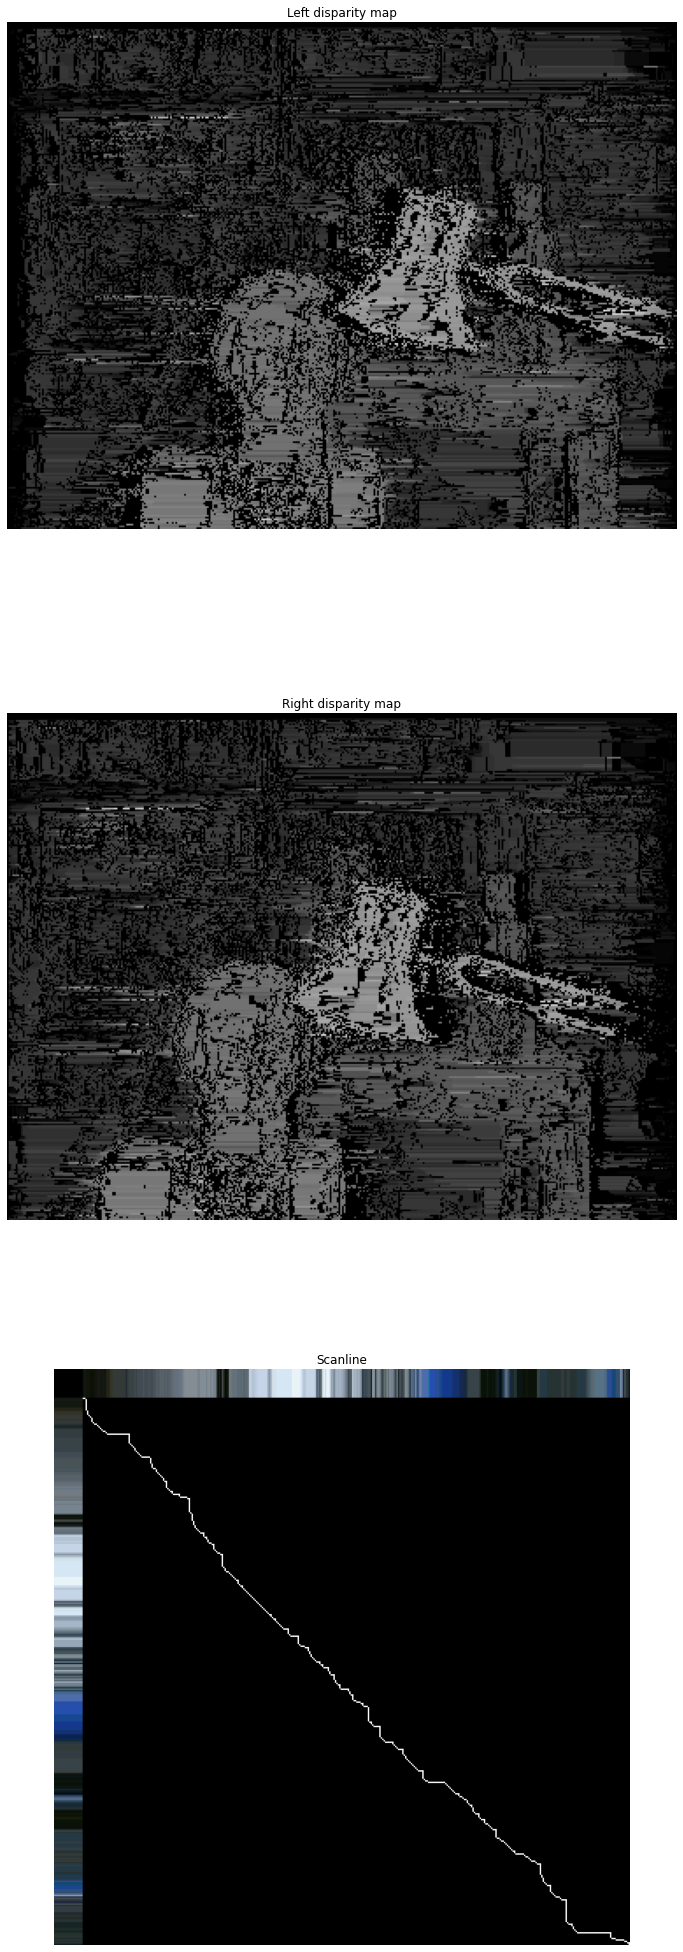

In [7]:
test_stereo_match('./l1.png', './r1.png', c=2, sigma=4)

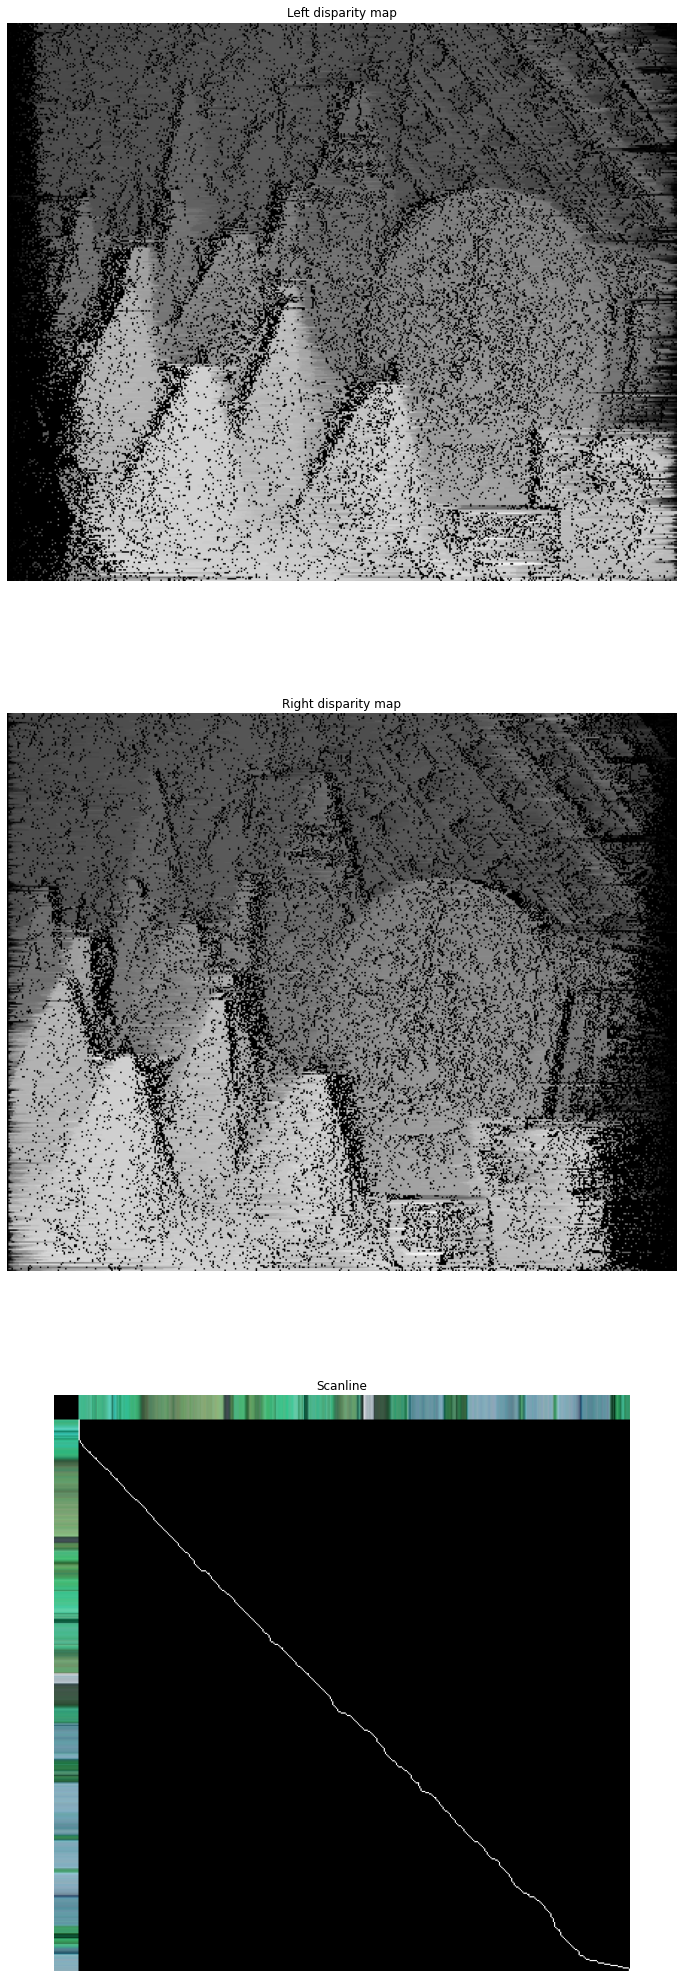

In [101]:
test_stereo_match('./l2.png', './r2.png', c=2, sigma=8)

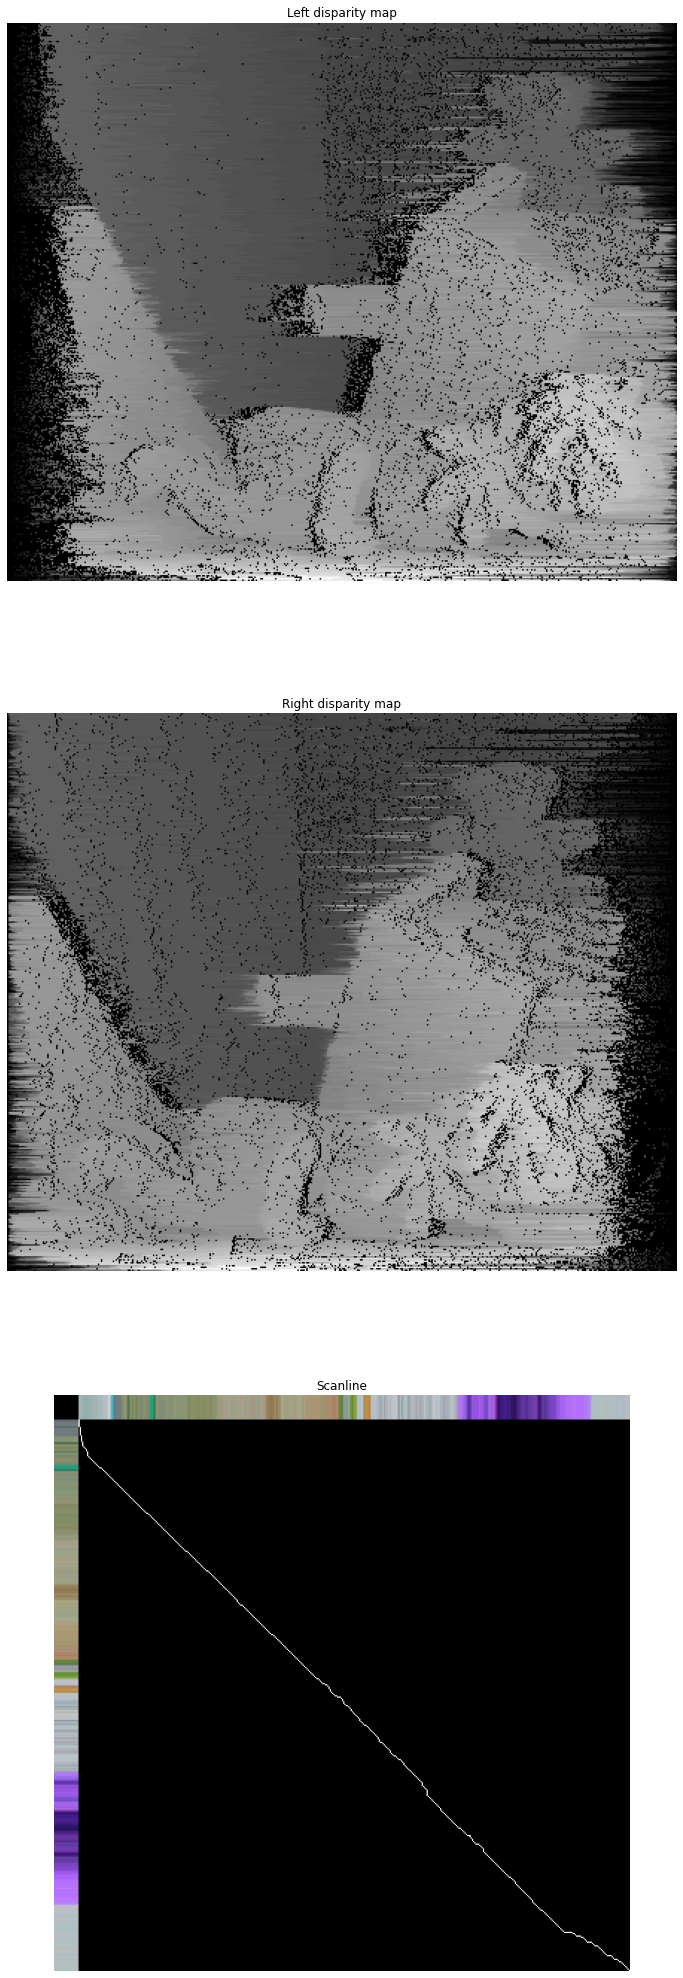

In [106]:
test_stereo_match('./l3.png', './r3.png', c=5, sigma=6)